In [1]:
push!(LOAD_PATH,".")
using CSV, DataFrames, Plots
using Chakra, Viewpoints, PPM
using Nova

In [2]:
melodies = map(fn->string("nova/",fn,"/track1"),readdir("nova"))
id_seqs = [obind(find(m,data),particles) for m in melodies]
seqs = [Chakra.sequence(s,data) for s in id_seqs]
pitch_view = [PPM.View(seq,vp(:pitch),vp(:pitch)) for seq in seqs];

# Parameters

In [3]:
a = Set([54:77...,79,81])
b = Backoff()
e = A()
u = true
o = Bounded(5)
#o = Unbounded();
idyom_model = "./idyom-data/STMA5.csv"

"./idyom-data/STMA5.csv"

# Compute Models

In [4]:
@time pitch_stm = PPM.ppm_stm(pitch_view,a,b,e,u,o);
PPM.mean_infcontent(pitch_stm)

  1.652943 seconds (13.47 M allocations: 1.367 GiB, 15.84% gc time, 34.87% compilation time)


3.1252478390427516

In [5]:
@time pitch_ltm = PPM.ppm_ltm(pitch_view,a,b,e,u,o);
PPM.mean_infcontent(pitch_ltm)

  2.303481 seconds (17.58 M allocations: 1.706 GiB, 21.58% gc time, 29.65% compilation time)


3.1884859734396596

In [6]:
@time pitch_ltm_plus = PPM.ppm_ltm_plus(pitch_view,a,b,e,u,o);
PPM.mean_infcontent(pitch_ltm_plus)

  2.379473 seconds (18.06 M allocations: 1.849 GiB, 33.30% gc time, 9.77% compilation time)


2.9235090946412456

In [7]:
@time pitch_both = PPM.ppm_both(pitch_view,a,b,e,u,o);
PPM.mean_infcontent(pitch_both)

  3.157775 seconds (30.02 M allocations: 3.060 GiB, 18.46% gc time, 17.98% compilation time)


2.576812470419125

In [8]:
@time pitch_both_plus = PPM.ppm_both_plus(pitch_view,a,b,e,u,o);
PPM.mean_infcontent(pitch_both_plus)

  3.429613 seconds (30.19 M allocations: 3.182 GiB, 25.32% gc time, 2.68% compilation time)


2.5332750302742

# Print Table 

In [9]:
pitch_table = PPM.todataframe(pitch_stm)

,SeqID,EventID,Symbol,Order,Prob,IC,H
,Int64,Int64,Int64,Int64,Float64,Float64,Float64
1,1,1,65,-1,0.0384615,4.70044,4.70044
2,1,2,62,-1,0.0196078,5.67243,3.27612
3,1,3,60,-1,0.0135135,6.20945,3.07171
4,1,4,60,0,0.252632,1.98489,3.09494
5,1,5,60,1,0.503497,0.989946,2.51433
6,1,6,60,2,0.503497,0.989946,2.51433
7,1,7,65,0,0.167832,2.57491,2.51433
8,1,8,65,0,0.143284,2.80305,1.99356
9,1,9,65,1,0.334262,1.58095,2.10954


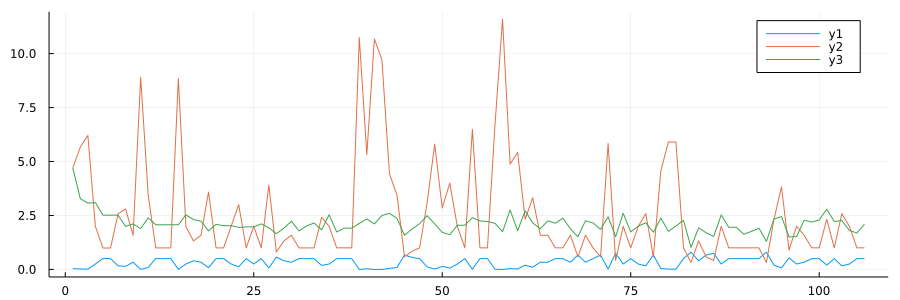

In [10]:
plot(pitch_table.Prob[1:106])
plot!(pitch_table.IC[1:106])
plot!(pitch_table.H[1:106])
plot!(size=(900,300))

# Comparison with IDyOM

In [11]:
idyom_data = CSV.File(idyom_model) |> DataFrame;
idyom_prob = idyom_data[!,"probability"];
idyom_ic = idyom_data[!,"information.content"]
DataFrame(Symbol = pitch_table.Symbol, Idyom = idyom_prob, Julia = pitch_table.Prob)

,Symbol,Idyom,Julia
,Int64,Float64,Float64
1,65,0.0384615,0.0384615
2,62,0.0196078,0.0196078
3,60,0.0135135,0.0135135
4,60,0.252632,0.252632
5,60,0.503497,0.503497
6,60,0.503497,0.503497
7,65,0.167832,0.167832
8,65,0.143284,0.143284
9,65,0.334262,0.334262


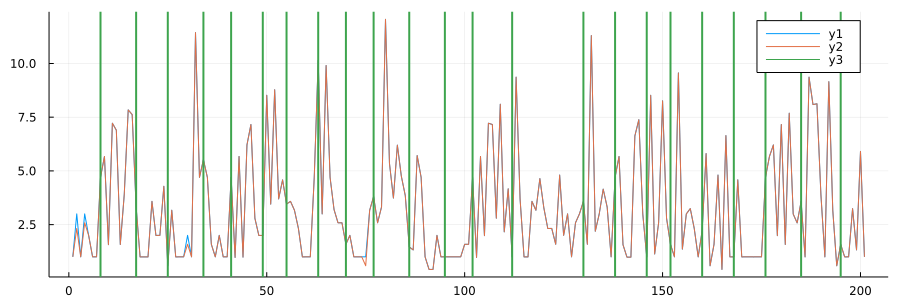

In [12]:
plot(idyom_ic[100:300])
plot!(pitch_table.IC[100:300])
phrases = findall(x->x==1,idyom_data[!,"phrase"][100:300]);
vline!(phrases, lw = 2)
plot!(size=(900,300))

# Multiple Viewpoint Models

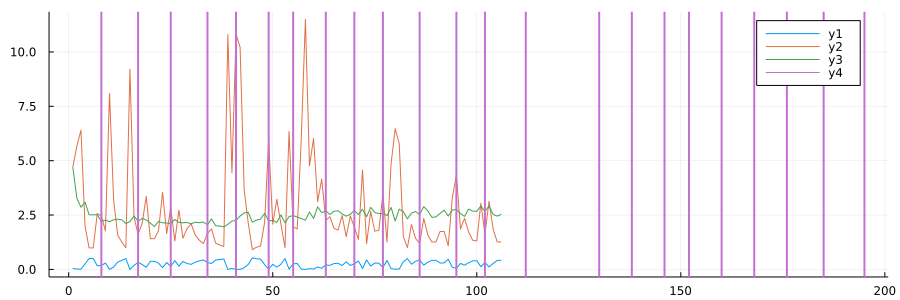

In [13]:
duration_view = [PPM.View(seq,vp(:duration),vp(:pitch)) for seq in seqs];
duration_stm = PPM.ppm_stm(duration_view,a,b,e,u,o);
pitch_duration_stm = [[PPM.combine([p1,p2],0) for (p1,p2) in zip(s,l)] for (s,l) in zip(pitch_stm,duration_stm)];
pitch_duration_table = PPM.todataframe(pitch_duration_stm);
plot(pitch_duration_table.Prob[1:106])
plot!(pitch_duration_table.IC[1:106])
plot!(pitch_duration_table.H[1:106])
vline!(phrases, lw = 2)
plot!(size=(900,300))

In [14]:
pdiff = Viewpoints.diff(vp(:pitch))

Viewpoints.DerivedViewpoint{Int64}(Viewpoints.LinkedViewpoint{Tuple{Int64, Int64}}(Viewpoint[Viewpoints.AtomicViewpoint{Int64}(:pitch, DataType[Int64]), Viewpoints.DelayedViewpoint{Int64}(Viewpoints.AtomicViewpoint{Int64}(:pitch, DataType[Int64]), 1)], DataType[Int64, Int64]), Viewpoints.var"#9#10"(), #undef)

In [15]:
pdiff(seqs[1])

0